Starter Pack

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrow
from IPython.display import HTML

In [2]:
dataframes = {}
folder = r'C:\Users\MATHEUS\Desktop\Pessoal\Competicoes\Kaggle\Big Data Bowl'

for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        full_path= os.path.join(folder,filename)
        df = pd.read_csv(full_path)
        dataframes[filename.removesuffix('.csv')]=df

In [3]:
indexlist = ['gameId','playId','nflId']
for key in dataframes.keys():
    existingindex = [col for col in dataframes[key].columns if col in indexlist]
    dataframes[key].set_index(existingindex, inplace=True)

In [4]:
pos_dict = dataframes['players']['position'].to_dict()
display_dict = dataframes['players']['displayName'].to_dict()

dataframes['player_play']['position'] = dataframes['player_play'].index.get_level_values('nflId').map(pos_dict)
dataframes['player_play']['displayName'] = dataframes['player_play'].index.get_level_values('nflId').map(display_dict)


In [5]:
#Add what penalty happened during a play in a game
#Helps track if the player play was helped by penalty
dataframes['player_play']['penaltyInPlay'] = dataframes['player_play'].groupby(['gameId', 'playId'])['penaltyNames'].transform('first')


Receivers Code

In [6]:
#Define the columns to visualize
standardplayerplaywr = ['position','displayName','teamAbbr','hadPassReception','receivingYards','wasTargettedReceiver','yardageGainedAfterTheCatch','penaltyInPlay','inMotionAtBallSnap','shiftSinceLineset','motionSinceLineset','wasRunningRoute','routeRan']

Tracking Foward Pass (Pass travelled more than 5 yards)

In [7]:
def isFowardPass(df):
    fowardpassindex = dataframes['plays'].query('passLength >= 5').index
    havefowardpass = df.index.droplevel('nflId').isin(fowardpassindex)\
                         & (df['wasTargettedReceiver']==1)
    return havefowardpass

Tracking Separation Fowls: Ineligble Man Downfield, OPI, Receiver Holding, Illegal hands to the face, Illegal motion, Offense Offside, Facemask


In [8]:
#Track if the pass travelled more than 5 yards and was helped with penalty
def penaltyInterferenceReceiver(df, n):
    penaltyList = ['Ineligible Downfield Pass','Offensive Pass Interference', 'Illegal Shift']
    fowlreviewplay = dataframes['player_play'][dataframes['player_play']['penaltyNames'].isin(penaltyList)]
    fowlreviewindex = fowlreviewplay.droplevel('nflId').index
    haveInterference = df.index.droplevel('nflId').isin(fowlreviewindex)\
                          & df.index.get_level_values('nflId').isin(n_targetreceivers(n))\
                          & (df['hadPassReception']==1)\
                          & isFowardPass(df)
    return haveInterference

Receivers with at least n targets

In [9]:
def n_targetreceivers(n):    
    receivers_playdf = dataframes['player_play'].groupby('nflId')
    receivers_play = receivers_playdf['wasTargettedReceiver'].sum()[receivers_playdf['wasTargettedReceiver'].sum() >= n]
    receivers_ids = list(receivers_play.reset_index()['nflId'])
    return receivers_ids

In [10]:
#Set n
n=10

#Set conditions
playerplayntgt = dataframes['player_play'][dataframes['player_play'].index.get_level_values('nflId').isin(n_targetreceivers(n))]
playerplayntgt[~penaltyInterferenceReceiver(playerplayntgt, 5) & isFowardPass(playerplayntgt)][standardplayerplaywr]

position       displayName teamAbbr  hadPassReception  \
gameId     playId nflId                                                         
2022090800 56     42489       WR      Stefon Diggs      BUF                 1   
           167    42489       WR      Stefon Diggs      BUF                 1   
           236    52536       WR        Gabe Davis      BUF                 1   
           364    44881       WR       Cooper Kupp       LA                 1   
           486    44881       WR       Cooper Kupp       LA                 1   
...                          ...               ...      ...               ...   
2022110700 3299   53098       WR  Marquez Callaway       NO                 1   
           3347   46160       WR    Tre'Quan Smith       NO                 1   
           3401   46160       WR    Tre'Quan Smith       NO                 1   
           3458   53098       WR  Marquez Callaway       NO                 0   
           3480   52942       TE     Juwan Johnson       NO                 1   

                         receivingYards  wasTargettedReceiver  \
gameId     playId nflId                                         
2022090800 56     42489               6                     1   
           167    42489              12                     1   
           236    52536              26                     1   
           364    44881              23                     1   
           486    44881               6                     1   
...                                 ...                   ...   
2022110700 3299   53098               5                     1   
           3347   46160               7                     1   
           3401   46160               9                     1   
           3458   53098               0                     1   
           3480   52942              41                     1   

                         yardageGainedAfterTheCatch penaltyInPlay  \
gameId     playId nflId                                             
2022090800 56     42489                           1          None   
           167    42489                           6          None   
           236    52536                          11          None   
           364    44881                           1          None   
           486    44881                           0          None   
...                                             ...           ...   
2022110700 3299   53098                           0          None   
           3347   46160                           2          None   
           3401   46160                           1          None   
           3458   53098                           0          None   
           3480   52942                          30          None   

                        inMotionAtBallSnap shiftSinceLineset  \
gameId     playId nflId                                        
2022090800 56     42489              False             False   
           167    42489              False             False   
           236    52536               True             False   
           364    44881              False             False   
           486    44881              False             False   
...                                    ...               ...   
2022110700 3299   53098              False             False   
           3347   46160              False             False   
           3401   46160              False             False   
           3458   53098              False             False   
           3480   52942              False             False   

                        motionSinceLineset  wasRunningRoute routeRan  
gameId     playId nflId                                               
2022090800 56     42489               True              1.0       IN  
           167    42489              False              1.0    SLANT  
           236    52536               True              1.0   CORNER  
           364    44881               

OL and DL code

In [11]:
#Define columns to visualize, some may be inserted later
standardOLplayerplay = ['position','displayName','teamAbbr','penaltyNames','penaltyInPlay','blockedPlayerNFLId1','blockedPlayerPosition1','blockedPlayerDisplayName1','blockedPlayerNFLId2','blockedPlayerPosition2','blockedPlayerDisplayName2','blockedPlayerNFLId3','blockedPlayerPosition3','blockedPlayerDisplayName3','pressureAllowedAsBlocker','timeToPressureAllowedAsBlocker']
standardDLplayerplay = ['position','displayName','teamAbbr','penaltyNames','penaltyInPlay','forcedFumbleAsDefense','halfSackYardsAsDefense','passDefensed','quarterbackHit','sackYardsAsDefense','safetyAsDefense','wasInitialPassRusher','causedPressure','timeToPressureAsPassRusher','getOffAsPassRusher']

In [12]:
#Find rushers players blocked
rusherset = set(dataframes['player_play']['blockedPlayerNFLId1'].dropna().astype(int)) | \
            set(dataframes['player_play']['blockedPlayerNFLId2'].dropna().astype(int)) | \
            set(dataframes['player_play']['blockedPlayerNFLId3'].dropna().astype(int))
rusherindex = list(rusherset)
rushersdf = dataframes['players'][dataframes['players'].index.isin(rusherindex)]

In [39]:
def transformfloattoint(df, fill = 0):
    return df.fillna(fill).astype('Int64').replace(fill, np.nan)

In [23]:
#Replace float values with int to track index

dataframes['player_play'][['blockedPlayerNFLId1','blockedPlayerNFLId2','blockedPlayerNFLId3']] = transformfloattoint(dataframes['player_play'][['blockedPlayerNFLId1','blockedPlayerNFLId2','blockedPlayerNFLId3']].fillna(0).astype('Int64').replace(0, np.nan))


In [14]:
dataframes['player_play'][['blockedPlayerPosition1','blockedPlayerPosition2','blockedPlayerPosition3']] = dataframes['player_play'][['blockedPlayerNFLId1','blockedPlayerNFLId2','blockedPlayerNFLId3']].applymap(lambda x: pos_dict.get(x, x))
dataframes['player_play'][['blockedPlayerDisplayName1','blockedPlayerDisplayName2','blockedPlayerDisplayName3']] = dataframes['player_play'][['blockedPlayerNFLId1','blockedPlayerNFLId2','blockedPlayerNFLId3']].applymap(lambda x: display_dict.get(x, x))
dataframes['player_play'][standardOLplayerplay]

position          displayName teamAbbr penaltyNames  \
gameId     playId nflId                                                       
2022090800 56     35472        G       Rodger Saffold      BUF          NaN   
                  42392        C          Mitch Morse      BUF          NaN   
                  42489       WR         Stefon Diggs      BUF          NaN   
                  44875        T         Dion Dawkins      BUF          NaN   
                  44985       WR      Isaiah McKenzie      BUF          NaN   
...                          ...                  ...      ...          ...   
2022110700 3787   52666        G  Calvin Throckmorton       NO          NaN   
                  52942       TE        Juwan Johnson       NO          NaN   
                  53098       WR     Marquez Callaway       NO          NaN   
                  54476       WR          Chris Olave       NO          NaN   
                  55125        G           Lewis Kidd       NO          NaN   

                        penaltyInPlay  blockedPlayerNFLId1  \
gameId     playId nflId                                      
2022090800 56     35472          None                47917   
                  42392          None                47917   
                  42489          None                 <NA>   
                  44875          None                43335   
                  44985          None                 <NA>   
...                               ...                  ...   
2022110700 3787   52666          None                 <NA>   
                  52942          None                 <NA>   
                  53098          None                 <NA>   
                  54476          None                 <NA>   
                  55125          None                 <NA>   

                        blockedPlayerPosition1 blockedPlayerDisplayName1  \
gameId     playId nflId                                                    
2022090800 56     35472                     NT               Greg Gaines   
                  42392                     NT               Greg Gaines   
                  42489                   <NA>                      <NA>   
                  44875                     DT          A'Shawn Robinson   
                  44985                   <NA>                      <NA>   
...                                        ...                       ...   
2022110700 3787   52666                   <NA>                      <NA>   
                  52942                   <NA>                      <NA>   
                  53098                   <NA>                      <NA>   
                  54476                   <NA>                      <NA>   
                  55125                   <NA>                      <NA>   

                         blockedPlayerNFLId2 blockedPlayerPosition2  \
gameId     playId nflId                                               
2022090800 56     35472                 <NA>                   <NA>   
                  42392                 <NA>                   <NA>   
                  42489                 <NA>                   <NA>   
                  44875                 <NA>                   <NA>   
                  44985                 <NA>                   <NA>   
...                                      ...                    ...   
2022110700 3787   52666                 <NA>                   <NA>   
                  52942                 <NA>                   <NA>   
                  53098                 <NA>                   <NA>   
                  54476                 <NA>                   <NA>   
                  55125                 <NA>                   <NA>   

                        blockedPlayerDisplayName2  blockedPlayerNFLId3  \
gameId     playId nflId                                                  
2022090800 56     35472                      <NA>                 <NA>   
                  42392                      <NA>     

In [15]:
#Find Plays that have passes
passplayindex = dataframes['plays'][dataframes['plays']['isDropback']==True].index

In [16]:
#Find Blocker player plays
isblocker = ~dataframes['player_play']['pressureAllowedAsBlocker'].isna()
isPassPlay = dataframes['player_play'].index.droplevel('nflId').isin(passplayindex)
dataframes['player_play'][isblocker & isPassPlay][standardOLplayerplay]


position          displayName teamAbbr penaltyNames  \
gameId     playId nflId                                                       
2022090800 56     35472        G       Rodger Saffold      BUF          NaN   
                  42392        C          Mitch Morse      BUF          NaN   
                  44875        T         Dion Dawkins      BUF          NaN   
                  48512        C           Ryan Bates      BUF          NaN   
                  53522        T        Spencer Brown      BUF          NaN   
...                          ...                  ...      ...          ...   
2022110700 3480   41532        T          James Hurst       NO          NaN   
                  42356        G          Andrus Peat       NO          NaN   
                  44844        T         Ryan Ramczyk       NO          NaN   
                  52432        G           Cesar Ruiz       NO          NaN   
                  52666        G  Calvin Throckmorton       NO          NaN   

                        penaltyInPlay  blockedPlayerNFLId1  \
gameId     playId nflId                                      
2022090800 56     35472          None                47917   
                  42392          None                47917   
                  44875          None                43335   
                  48512          None                41239   
                  53522          None                43298   
...                               ...                  ...   
2022110700 3480   41532          None                53460   
                  42356          None                41363   
                  44844          None                37145   
                  52432          None                41363   
                  52666          None                54541   

                        blockedPlayerPosition1 blockedPlayerDisplayName1  \
gameId     playId nflId                                                    
2022090800 56     35472                     NT               Greg Gaines   
                  42392                     NT               Greg Gaines   
                  44875                     DT          A'Shawn Robinson   
                  48512                     DT              Aaron Donald   
                  53522                     DE             Leonard Floyd   
...                                        ...                       ...   
2022110700 3480   41532                    OLB                Odafe Oweh   
                  42356                     DE               Brent Urban   
                  44844                    OLB            Justin Houston   
                  52432                     DE               Brent Urban   
                  52666                     DT              Travis Jones   

                         blockedPlayerNFLId2 blockedPlayerPosition2  \
gameId     playId nflId                                               
2022090800 56     35472                 <NA>                   <NA>   
                  42392                 <NA>                   <NA>   
                  44875                 <NA>                   <NA>   
                  48512                 <NA>                   <NA>   
                  53522                 <NA>                   <NA>   
...                                      ...                    ...   
2022110700 3480   41532                 <NA>                   <NA>   
                  42356                 <NA>                   <NA>   
                  44844                 <NA>                   <NA>   
                  52432                 <NA>                   <NA>   
                  52666                 <NA>                   <NA>   

                        blockedPlayerDisplayName2  blockedPlayerNFLId3  \
gameId     playId nflId                                                  
2022090800 56     35472                      <NA>                 <NA>   
                  42392                      <NA>     

Track WR movement, Adjusting metrics using week 1 data

In [48]:
#Set nflId and jerseynumber to Int64 
dataframes['tracking_week_1'] = dataframes['tracking_week_1'].reset_index(level='nflId')
dataframes['tracking_week_1'][['nflId','jerseyNumber']] = transformfloattoint(dataframes['tracking_week_1'][['nflId','jerseyNumber']], fill = -1)
dataframes['tracking_week_1'] = dataframes['tracking_week_1'].set_index('nflId', append=True).reorder_levels(['gameId', 'playId', 'nflId'])

                            displayName  frameId    frameType  \
gameId     playId nflId                                         
2022091200 64     35459  Kareem Jackson        1  BEFORE_SNAP   
                  35459  Kareem Jackson        2  BEFORE_SNAP   
                  35459  Kareem Jackson        3  BEFORE_SNAP   
                  35459  Kareem Jackson        4  BEFORE_SNAP   
                  35459  Kareem Jackson        5  BEFORE_SNAP   

                                          time  jerseyNumber club  \
gameId     playId nflId                                             
2022091200 64     35459  2022-09-13 00:16:03.5            22  DEN   
                  35459  2022-09-13 00:16:03.6            22  DEN   
                  35459  2022-09-13 00:16:03.7            22  DEN   
                  35459  2022-09-13 00:16:03.8            22  DEN   
                  35459  2022-09-13 00:16:03.9            22  DEN   

                        playDirection      x      y     s   

In [49]:
firstplayindex = dataframes['tracking_week_1'].droplevel('nflId').iloc[0].name
testdf = dataframes['tracking_week_1'][dataframes['tracking_week_1'].droplevel('nflId').index.isin([firstplayindex])]

testdf

displayName  frameId    frameType  \
gameId     playId nflId                                         
2022091200 64     35459  Kareem Jackson        1  BEFORE_SNAP   
                  35459  Kareem Jackson        2  BEFORE_SNAP   
                  35459  Kareem Jackson        3  BEFORE_SNAP   
                  35459  Kareem Jackson        4  BEFORE_SNAP   
                  35459  Kareem Jackson        5  BEFORE_SNAP   
...                                 ...      ...          ...   
                  <NA>         football      159   AFTER_SNAP   
                  <NA>         football      160   AFTER_SNAP   
                  <NA>         football      161   AFTER_SNAP   
                  <NA>         football      162   AFTER_SNAP   
                  <NA>         football      163   AFTER_SNAP   

                                          time  jerseyNumber      club  \
gameId     playId nflId                                                  
2022091200 64     35459  2022-09-13 00:16:03.5            22       DEN   
                  35459  2022-09-13 00:16:03.6            22       DEN   
                  35459  2022-09-13 00:16:03.7            22       DEN   
                  35459  2022-09-13 00:16:03.8            22       DEN   
                  35459  2022-09-13 00:16:03.9            22       DEN   
...                                        ...           ...       ...   
                  <NA>   2022-09-13 00:16:19.3          <NA>  football   
                  <NA>   2022-09-13 00:16:19.4          <NA>  football   
                  <NA>   2022-09-13 00:16:19.5          <NA>  football   
                  <NA>   2022-09-13 00:16:19.6          <NA>  football   
                  <NA>   2022-09-13 00:16:19.7          <NA>  football   

                        playDirection          x      y     s     a   dis  \
gameId     playId nflId                                                     
2022091200 64     35459         right  51.060000  28.55  0.72  0.37  0.07   
                  35459         right  51.130000  28.57  0.71  0.36  0.07   
                  35459         right  51.200000  28.59  0.69  0.23  0.07   
                  35459         right  51.260000  28.62  0.67  0.22  0.07   
                  35459         right  51.320000  28.65  0.65  0.34  0.07   
...                               ...        ...    ...   ...   ...   ...   
                  <NA>          right  40.380001   1.39  2.04  3.87  0.23   
                  <NA>          right  40.400002   1.21  1.64  3.49  0.18   
                  <NA>          right  40.419998   1.09  1.14  3.37  0.13   
                  <NA>          right  40.430000   0.99  0.87  2.49  0.10   
                  <NA>          right  40.439999   0.95  0.33  2.76  0.04   

                              o    dir                 event  
gameId     playId nflId                                       
2022091200 64     35459  246.17  68.34  huddle_break_offense  
                  35459  245.41  71.21                   NaN  
                  35459  244.45  69.90                   NaN  
                  35459  244.45  67.98                   NaN  
                  35459  245.74  62.83                   NaN  
...                         ...    ...                   ...  
                  <NA>      NaN    NaN                tackle  
                  <NA>      NaN    NaN                   NaN  
                  <NA>      NaN    NaN                   NaN  
                  <NA>      NaN    NaN                   NaN  
                  <NA>      NaN    NaN                   NaN  

[3749 rows x 15 columns]

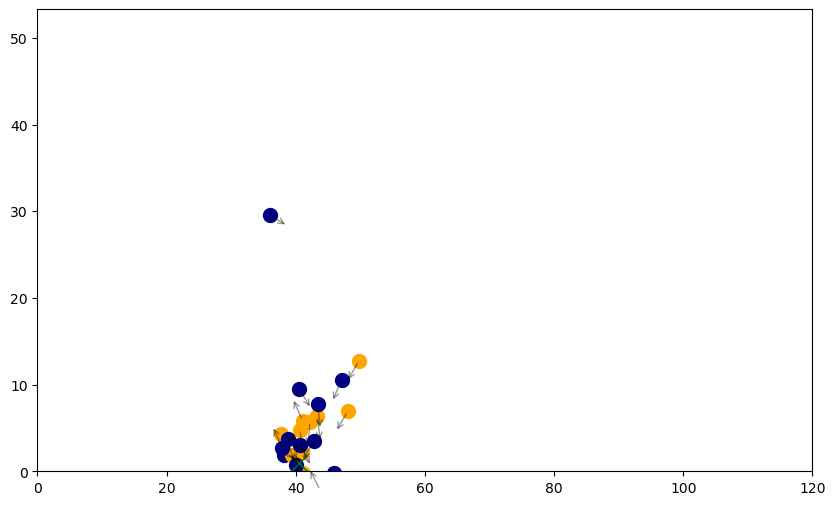

In [61]:
# Configurar o gráfico

fig, ax = plt.subplots(figsize=(10, 6))

# Definir limites do gráfico (campo de futebol, por exemplo)
ax.set_xlim(0, 120)
ax.set_ylim(0, 53.3)

# Mapear cores para os times
color_map = {'DEN': 'orange', 'SEA': 'navy'}

# Criar pontos para os jogadores
players_dots = {
    nfl_id: ax.plot([], [], 'o', markersize=10, label=f'Player {nfl_id}')[0]
    for nfl_id in testdf.index.get_level_values('nflId').unique() if not pd.isna(nfl_id)
}

ball_dot, = ax.plot([], [], 'x', color='green', markersize=12, label='Ball')

player_arrows = {
    nfl_id: ax.annotate('', xy=(0, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='black', alpha=0.4))
    for nfl_id in testdf.index.get_level_values('nflId').unique() if not pd.isna(nfl_id)
}

# Função de inicialização
def init():
    for dot in players_dots.values():
        dot.set_data([], [])
    for arrow in player_arrows.values():
        arrow.set_position((0, 0))
        arrow.xy = (0, 0)
    ball_dot.set_data([], [])
    return list(players_dots.values()) + [ball_dot] + list(player_arrows.values())

# Função para atualizar a animação
def update(frame):
    # Seleciona os dados dos jogadores para o frame atual
    current_frame = testdf[testdf['frameId'] == frame]
    
    # Atualiza a posição de cada jogador e a cor
    for nfl_id, dot in players_dots.items():
        player = current_frame[current_frame.index.get_level_values('nflId') == nfl_id]
        if not player.empty:
            x_pos = player['x'].values[0]
            y_pos = player['y'].values[0]
            orientation = player['o'].values[0]
            club = player['club'].values[0]
            dot.set_data([x_pos], [y_pos])
            dot.set_color(color_map.get(club, 'gray'))  # Atribui a cor com base no clube
            
            # Calcula o deslocamento da seta
            dx = np.sin(np.radians(orientation)) * 3  # Comprimento da seta
            dy = np.cos(np.radians(orientation)) * 3
            
            player_arrows[nfl_id].set_position((x_pos, y_pos)) 
            # Atualiza a seta
            player_arrows[nfl_id].xy = (x_pos + dx, y_pos + dy)
            player_arrows[nfl_id].xytext = (x_pos, y_pos)
    
    # Atualiza a posição da bola (nflId é NaN)
    ball_frame = current_frame[current_frame.index.get_level_values('nflId').isna()]
    if not ball_frame.empty:
        ball_x = ball_frame['x'].values[0]
        ball_y = ball_frame['y'].values[0]
        ball_dot.set_data([ball_x], [ball_y])
    
    # Retorna os pontos atualizados
    return list(players_dots.values()) + [ball_dot]

# Criar a animação com intervalos para aumentar a velocidade
ani = FuncAnimation(fig, update, frames=testdf['frameId'].unique(), init_func=init, blit=True, repeat=True, interval=50)

# Mostrar a animação no Jupyter Notebook com HTML
HTML(ani.to_jshtml())